## Example analysis of barcoded codon variants

Here is an example of analyzing barcoded coding variants of a gene. The
analysis first simulates an “plausible” data set. It then analyzes the
simulated data.

Most of the analysis is done by using a
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
to store and analyze the variants and their sequencing counts.

### Setup for analysis

We import key classes and functions from
[dms_tools2.codonvarianttable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html).

We use [plotnine](https://plotnine.readthedocs.io) for ggplot2-like
plotting syntax:

In [1]:
import collections
import os
import math
import tempfile

import random
import scipy
import pandas as pd

from plotnine import *

from dms_tools2 import CODONS, CODON_TO_AA, NTS, AAS_WITHSTOP
NONSTOP_CODONS = [c for c in CODONS if CODON_TO_AA[c] != '*']
from dms_tools2.codonvarianttable import CodonVariantTable, \
                                         simulateSampleCounts, \
                                         PhenotypeSimulator, \
                                         CBPALETTE

Seed random number generators for reproducible output:

In [2]:
random.seed(1)
scipy.random.seed(1)

Set pandas display options to show large chunks of Data Frames in this
example:

In [3]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

# Initialize a CodonVariantTable

We create a
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
with simulated data.

## Simulate variants

Define a wildtype gene sequence of 50 codons. We will then build a table
of variants of this wildtype sequence.

In [4]:
genelength = 50
geneseq = ''.join(random.choices(NONSTOP_CODONS, k=genelength))
geneseq

'AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA'

We now initialize a
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html).
Normally you would do this using the constructor for that class
described in the link above, which takes as input a
CSV file giving the barcodes and nucleotide substitutions in
the gene (in 1, 2, … numbering) for each variant, as well as the library
to which each variant belongs to (we always have at least
one library, but hopefully you have replicate libraries), and the
variant call support. The variant call support is confident you are that
the variant is called correctly, and might be the number of PacBio CCSs
that support that variant.

However, here we are just simulating data, so we create the
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
using its [from_simulation](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.from_simulation) method.
We simulate the variants for two libraries. Each library has a
number of variants that is 400-times the codon-length of the gene, and
barcodes are of length 16. We will have a Poisson distributed number of
codon mutations per variant with a mean of 1.3:

In [5]:
libs = ['lib_1', 'lib_2']
variants_per_lib = 400 * genelength

variants = CodonVariantTable.from_simulation(
            geneseq=geneseq,
            bclen=16,
            library_specs={lib: {'avgmuts': 1.3, 'nvariants': variants_per_lib}
                           for lib in libs},
            variant_call_support=(1, 3),
            seed=None
            )

Now  is a
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
with the data on our barcodes and variants. We can get basic information
about the wildtype codon and amino-acid identities at each site using
the , , and  attributes of the table. For
instance:

In [6]:
variants.sites[ : 10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [7]:
list(variants.codons[r] for r in variants.sites[ : 10])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG', 'CGT', 'GCT', 'TAC', 'ACC', 'AAC']

In [8]:
list(variants.aas[r] for r in variants.sites[ : 10])

['R', 'S', 'V', 'I', 'L', 'R', 'A', 'Y', 'T', 'N']

We can get a list of the libraries for which we have barcodes:

In [9]:
variants.libraries

['lib_1', 'lib_2']

We can also get a Data Frame that includes the information
about the variants along with additional columns containing amino-acid
mutations and mutation counts via the  attribute
of our
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html):

In [10]:
variants.barcode_variant_df.head(n=4)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAACGTTTTGTCC,1,AGA1TGT,R1C,1,1
1,lib_1,AAAAAAGACGACCCAT,1,AAC20TAA CGC26CAG,N20* R26Q,2,2
2,lib_1,AAAAAAGCTTCATTTG,3,AGA1CCG CGC26TGG AAC36TTA GGA50ATC,R1P R26W N36L G50I,4,4
3,lib_1,AAAAAAGGTGACAATA,3,GTA16TCA,V16S,1,1


# Analyze the codon variant table

The
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
has a large number of methods to get or plot information about the
variants (look at the
[documentation](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
for details on these methods).

Eventually, we will add the counts of different variants for specific
samples. But for now, we haven’t added any samples. However, we can use
the analysis methods of our
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
to get information about the variant composition itself by calling them
with . When we do that, we simply get

Get the number of variants in each library using
[CodonVariantTable.n_variants_df](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.n_variants_df):

In [11]:
variants.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,20000
1,lib_2,barcoded variants,20000
2,all libraries,barcoded variants,40000


Get the set of valid barcodes for each library using
[CodonVariantTable.valid_barcodes](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.valid_barcodes).
Here we just show the first few valid barcodes for the first library:

In [12]:
sorted(variants.valid_barcodes('lib_1'))[ : 3]

['AAAAAACGTTTTGTCC', 'AAAAAAGACGACCCAT', 'AAAAAAGCTTCATTTG']

Plots the number of mutations per variant using
[CodonVariantTable.plotNumMutsHistogram](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.plotNumMutsHistogram).
Here we do that for amino-acid mutations:

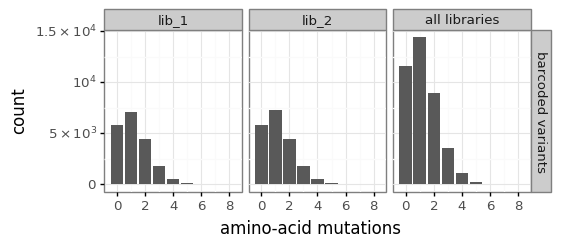

In [13]:
p = variants.plotNumMutsHistogram('aa', samples=None)
_ = p.draw()

We can make a similar plot for codon mutations:

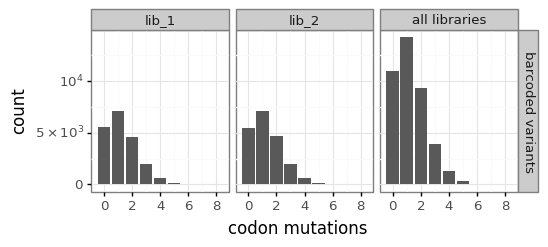

In [14]:
p = variants.plotNumMutsHistogram('codon', samples=None)
_ = p.draw()

Examine the average frequency of codon mutations of each type per
variant using
[CodonVariantTable.plotNumCodonMutsByType](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.plotNumCodonMutsByType).
First, we just do that for single-codon variants and wildtype:

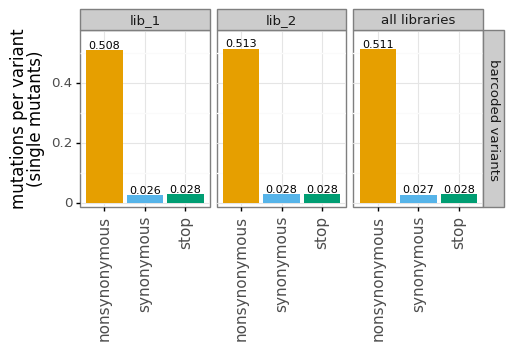

In [15]:
p = variants.plotNumCodonMutsByType('single', samples=None)
_ = p.draw()

Now for variants with any number of mutations:

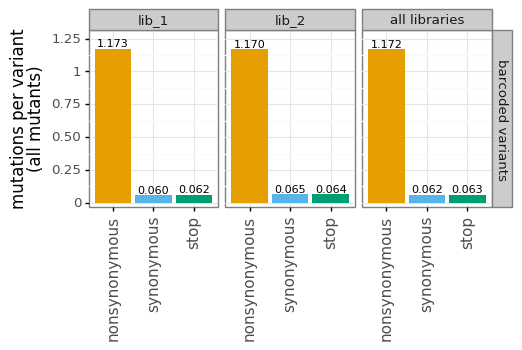

In [16]:
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Examine how well mutations are sampled in the library by looking at the
fraction of mutations seen <= some number of times using
[CodonVariantTable.plotCumulMutCoverage](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.plotCumulMutCoverage).
Here we do that for codon mutations, looking at just for the
single-codon mutants:

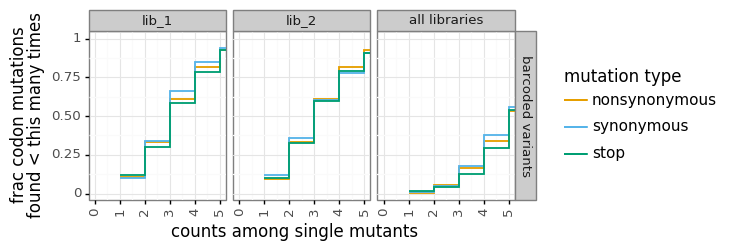

In [17]:
p = variants.plotCumulMutCoverage('single', 'codon', samples=None)
_ = p.draw()

We can also get the numerical information plotted above using
[CodonVariantTable.mutCounts](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.mutCounts)

In [18]:
variants.mutCounts('single', 'aa', samples=None).head(n=4)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,R1S,24,nonsynonymous,1
1,lib_1,barcoded variants,I28R,23,nonsynonymous,28
2,lib_1,barcoded variants,V3R,23,nonsynonymous,3
3,lib_1,barcoded variants,P24S,22,nonsynonymous,24


Here are the frequencies of mutations along the gene in our library
plotted using
[CodonVariantTable.plotMutFreqs](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.plotMutFreqs),
looking at just single amino-acid variants:

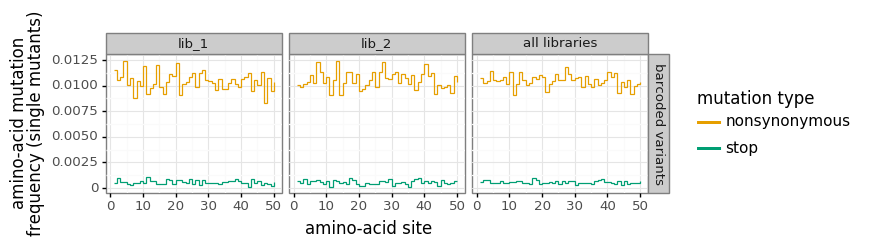

In [19]:
p = variants.plotMutFreqs('single', 'aa', samples=None)
_ = p.draw()

We can also look at comparable information in a heat-map form using
[CodonVariantTable.plotMutHeatMap](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.plotMutHeatMap):

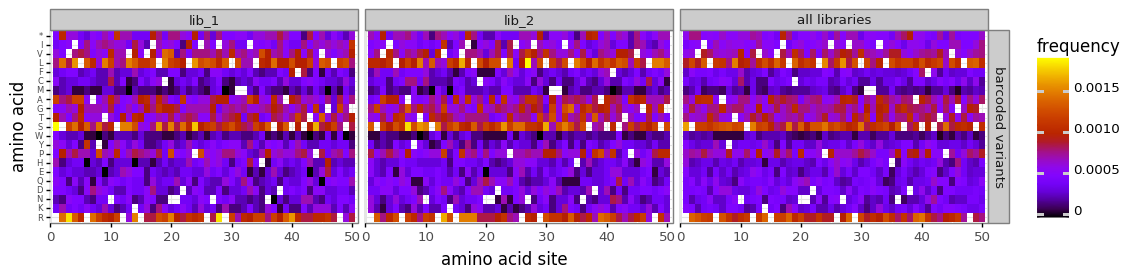

In [20]:
p = variants.plotMutHeatmap('single', 'aa', samples=None)
_ = p.draw()

Simulate variant counts

An experiment involves looking at how the counts of the different
variants changes under selection. In a **real** experiment, you would
obtain the variant counts by sequencing the barcodes pre- and
post-selection.

However, here we **simulate** an experiment by simulating codon counts
based on a known phenotype for each variant to show demonstrate the
analysis.

We use
[simulateSampleCounts](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.simulateSampleCounts)
to simulate data for an experiment. This function simulates the counts
of variants pre- and post-selection; the change in variant counts after
selection indicates the effect of a mutation.

# Define phenotype function

First, we define a “phenotype” function. We will do this using a
[PhenotypeSimulator](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.phenotypeSimulator),
which follow the concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the
phenotype in two steps: an underlying latent phenotype that mutations
affect additively, and then a non-linear relationship between this
latent phenotype and the observed phenotype.

First, we initialize a
[PhenotypeSimulator](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.phenotypeSimulator):

In [21]:
phenosimulator = PhenotypeSimulator(geneseq)

We plot the relationship of the latent and observed phenotypes, with a
dashed vertical line indicating the wildtype phenotype:

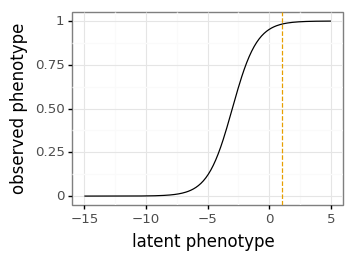

In [22]:
p = phenosimulator.plotLatentVersusObservedPhenotype()
_ = p.draw()

Next, we plot the latent and observed phenotypes of all single mutants,
with a dashed vertical line indicating the wildtype phenotype:

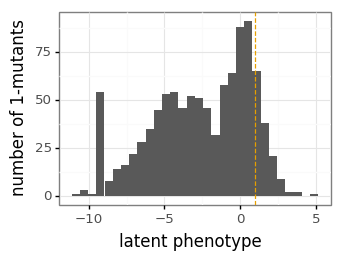

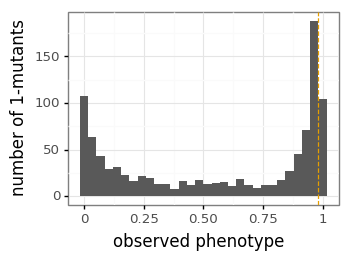

In [23]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

# Simulate variant counts for samples

Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.simulateSampleCounts)
to simulate the counts of variants assuming selection on each variant
proportional to its observed phenotype as defined above. This function
allows us to tune various aspects of the simulations to make them
reflect real experiments, such as by tweaking the error-rate in variant
calling, the sequencing depth, the bottlenecks during the experiment,
and non-uniformity in library composition.

We simulate under a range of conditions spanning reasonable values of
the parameters that are likely to affect the outcome of a real
experiment:

> * The case where the mutations in each variant are called
>   perfectly with no errors, and where 5% of them contain an erroneously
>   mis-called codon mutation.

> * Where there is a low
>   (small) or big (loose) bottleneck between the pre- and post-selection
>   steps. These bottlenecks are equal to 5 or 50 times the total number of
>   variants in each library.

For all simulations, we assume variant composition of the library is
reasonably but not completely uniform.
Although the code in the next cell is set up to simulate sequencing
to several different depths, here we only simulate “deep” depth
of 500 times the number of variants in the library.

Simulate sample counts under all of these conditions, and put them in a
data frame:

In [24]:
post_to_pre = {} # dict mapping each post-selection sample to its pre-selection sample
counts_df = [] # list of data frames for each selection

for err_str, err in [('', 0), ('err_', 0.05)]:

    for depth_str, depth in [('deep', 500 * variants_per_lib)]:

        sample_prefix = f"{err_str}{depth_str}_"
        pre_sample_name = sample_prefix + 'pre'
        post_lowbottle_sample_name = sample_prefix + 'lowbottle'
        post_bigbottle_sample_name = sample_prefix + 'bigbottle'
        post_to_pre[post_lowbottle_sample_name] = pre_sample_name
        post_to_pre[post_bigbottle_sample_name] = pre_sample_name

        counts_df.append(
                simulateSampleCounts(
                        variants=variants,
                        phenotype_func=phenosimulator.observedPhenotype,
                        variant_error_rate=err,
                        pre_sample={'total_count':depth,
                                    'uniformity':10},
                        pre_sample_name=pre_sample_name,
                        post_samples={
                            post_bigbottle_sample_name:{
                                    'total_count':depth,
                                    'noise':0,
                                    'bottleneck':50 * variants_per_lib},
                            post_lowbottle_sample_name:{
                                    'total_count':depth,
                                    'noise':0,
                                    'bottleneck':5 * variants_per_lib},
                            },
                        )
                 )
# combine all the simulated data frames
counts_df = pd.concat(counts_df)

pd.DataFrame.from_records(list(post_to_pre.items()),
                          columns=['post-selection', 'pre-selection'])

,post-selection,pre-selection
0,deep_lowbottle,deep_pre
1,deep_bigbottle,deep_pre
2,err_deep_lowbottle,err_deep_pre
3,err_deep_bigbottle,err_deep_pre


Here are the first few lines of the data frame with the simulated
counts:

In [25]:
counts_df.head(n=5)

,library,barcode,sample,count
0,lib_1,AAAAAACGTTTTGTCC,deep_pre,490
1,lib_1,AAAAAAGACGACCCAT,deep_pre,831
2,lib_1,AAAAAAGCTTCATTTG,deep_pre,424
3,lib_1,AAAAAAGGTGACAATA,deep_pre,701
4,lib_1,AAAAAATACGGTCAGC,deep_pre,394


# Add counts to variant table

We now add the simulated counts to the
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html)
using its
[addSampleCounts](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.addSampleCounts)
method:

In [26]:
for sample in counts_df['sample'].unique():
    for lib in libs:
        icounts = counts_df.query('sample == @sample & library == @lib')
        variants.addSampleCounts(lib, sample, icounts)

We use the
[CodonVariantTable.n_variants_df](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.n_variants_df)
method to confirm that we have the expected number of variant counts for
each sample:

In [27]:
variants.n_variants_df()

,library,sample,count
0,lib_1,deep_pre,10000000
1,lib_1,deep_bigbottle,10000000
2,lib_1,deep_lowbottle,10000000
3,lib_1,err_deep_pre,10000000
4,lib_1,err_deep_bigbottle,10000000
5,lib_1,err_deep_lowbottle,10000000
6,lib_2,deep_pre,10000000
7,lib_2,deep_bigbottle,10000000
8,lib_2,deep_lowbottle,10000000
9,lib_2,err_deep_pre,10000000


Analyze variant counts for samples

Now we analyze the variant counts for the samples that we have added to
our
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html).

# Directly access variant counts

The variant counts are in the  attribute of the
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html).
Here is what the first few lines of that Data Frame look like:

In [28]:
variants.variant_count_df.head(n=4)

,barcode,count,library,sample,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,AAATCACTAATATGGG,1308,lib_1,deep_pre,1,,,0,0
1,TTAATGAAAATAAGTC,1301,lib_1,deep_pre,1,GTG3ACA GTG13CGA CCT24GAG GAC38GAT CCA44ATC,V3T V13R P24E P44I,5,4
2,TGATAGAAATTATTTG,1294,lib_1,deep_pre,3,ATC17CGA,I17R,1,1
3,TTATCAATTGCGGATG,1294,lib_1,deep_pre,3,GTG3TAC AAA14CTC,V3Y K14L,2,2


# Distribution of variant counts

We plot the number of counts for each variant in each sample. The
horizontal line shows the total number of variants. The plot shows that
all variants are well-sampled in the pre-selection libraries, but that
post-selection some variants are not sampled or sampled very little.
This is as expected since selection will decrease and increase the
frequency of variants.

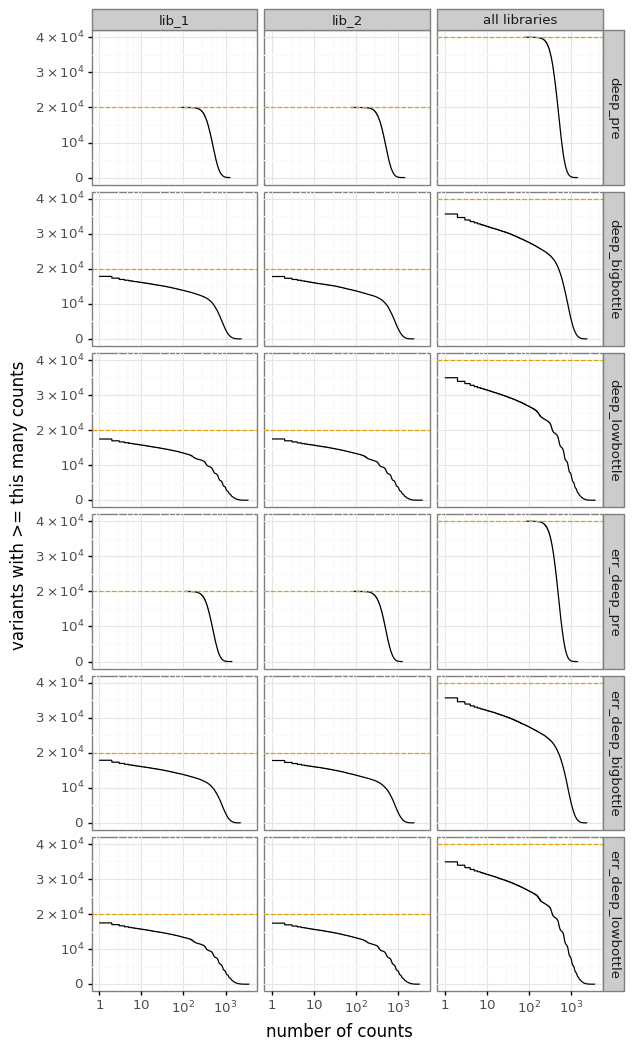

In [29]:
p = variants.plotCumulVariantCounts(heightscale=1.3, widthscale=1.2)
_ = p.draw()

# Mutation frequencies in each sample

We look at the counts of each variant as a function of the number of
amino-acid mutations. The plots
below show that selection enriches for variants with fewer mutations,
which is as expected since many mutations are deleterious:

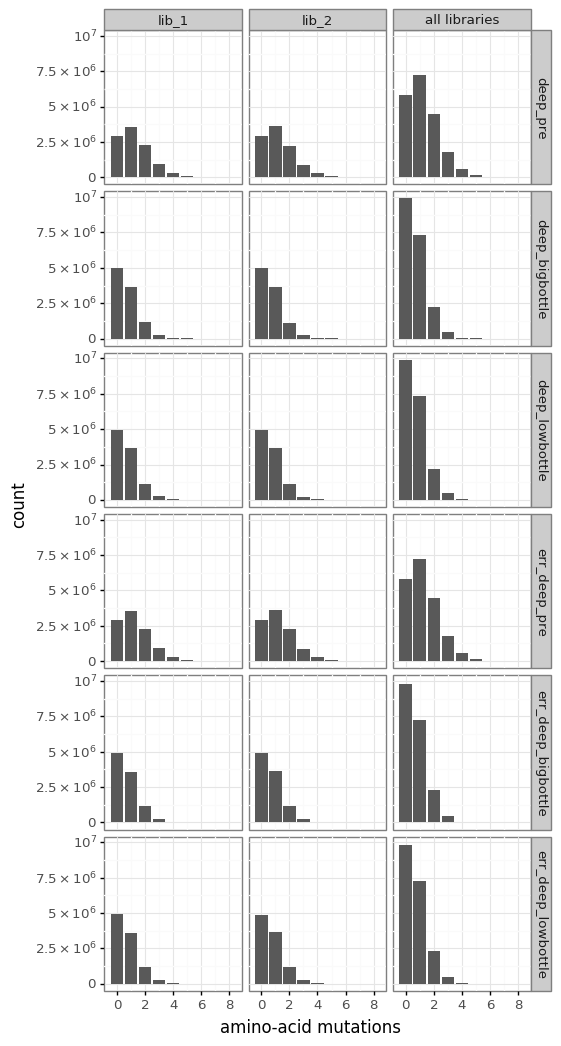

In [30]:
p = variants.plotNumMutsHistogram(mut_type='aa', heightscale=1.3)
_ = p.draw()

Next we plot the average number of codon mutations of each type
(nonsynonymous, synonymous, and stop). We do this for *all* variants (as
opposed to just single mutants). We see that as expected, there is
strong selection against stop codons, and some selection against
nonsynonymous ones:

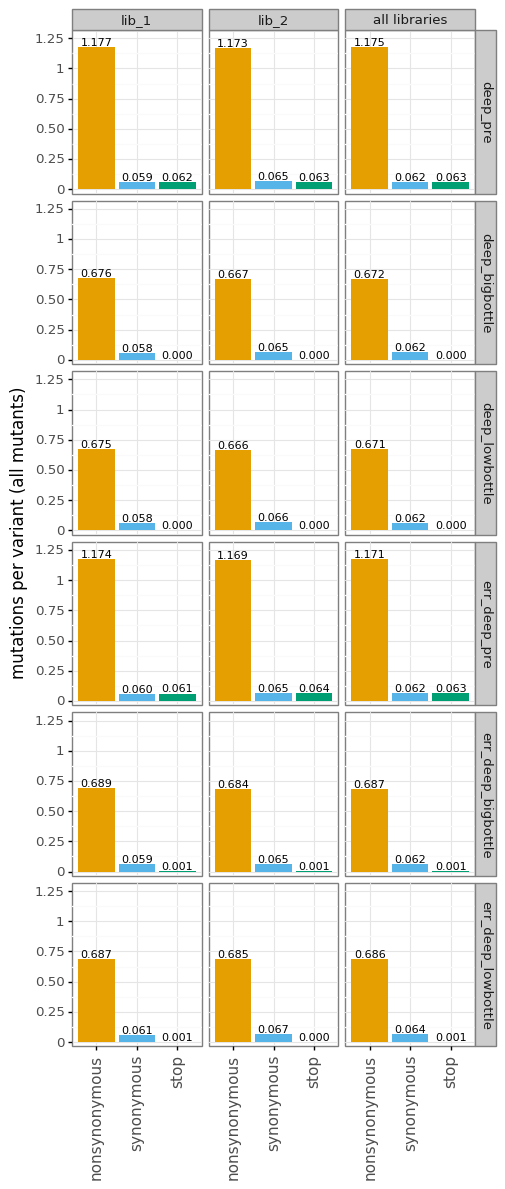

In [31]:
p = variants.plotNumCodonMutsByType('all', heightscale=1.5)
_ = p.draw()

Here are the mutation frequencies as a function of primary sequence.
This plot is for all variants, showing codon mutations:

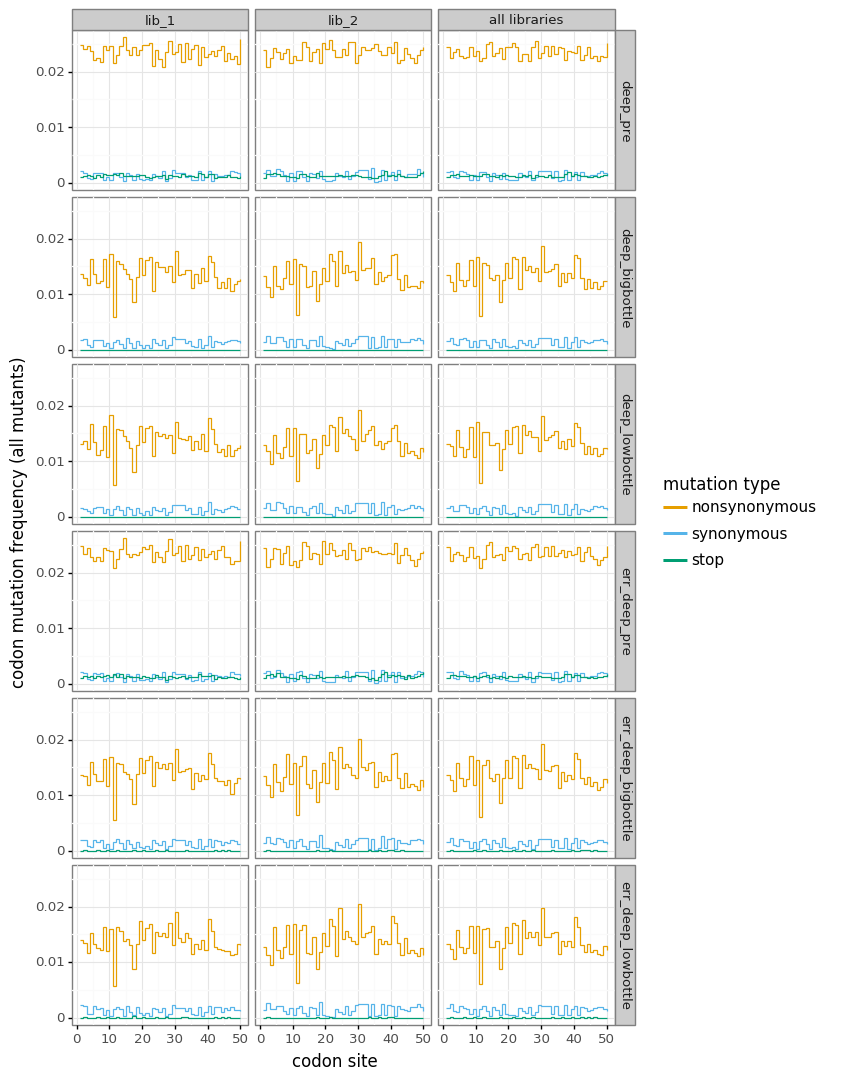

In [32]:
p = variants.plotMutFreqs(variant_type='all', mut_type='codon', heightscale=1.9)
_ = p.draw()

# Mutation sampling

We look at how thoroughly the different possible mutations are sampled
in our libraries by plotting the fraction of mutations found <= an
indicated number of times. We can do this separately for single-mutants
only or for all variants, and for codon or amino-acid mutations. Here we
do it all variants, showing codon mutations. As the plot below shows,
sampling of stop and to a lesser degree nonsynonymous mutations drops
strongly after selection, as expected since many of these are
deleterious:

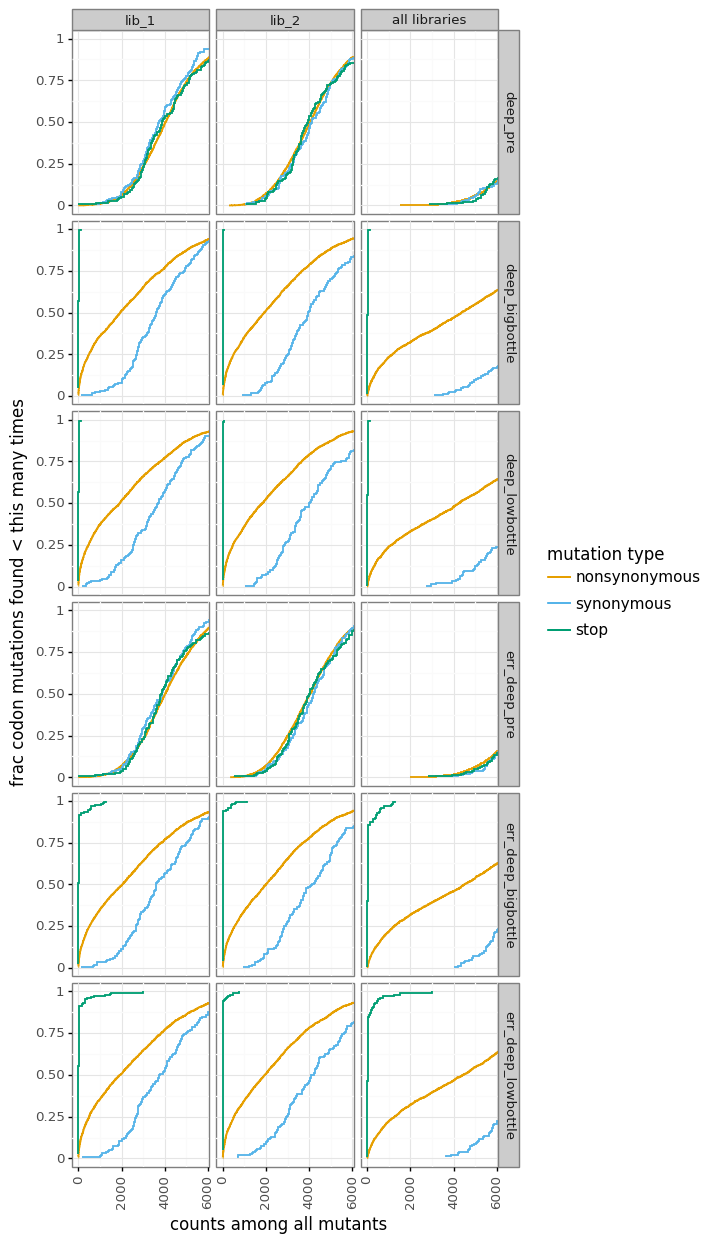

In [33]:
p = variants.plotCumulMutCoverage(variant_type='all', mut_type='codon',
                                  heightscale=1.8)
_ = p.draw()

Functional scores for variants

We want to estimate a functional score (similar to “fitness” in the
experimental assay) for each variant based on its change in frequency
post-selection relative to its initial pre-selection frequency.

# Calculate functional scores

We can calculate functional scores using the
[func_scores](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html#dms_tools2.codonvarianttable.CodonVariantTable.func_scores)
method of the
[CodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.codonvarianttable.html).
The documentation for that method explains exactly how the scores are
calculated.

In order to calculate functional scores, we need to pair each
post-selection sample with a pre-selection one. We use the pairing
described above when we simulated the samples, which we re-print here:

In [34]:
pd.DataFrame.from_records(list(post_to_pre.items()),
                          columns=['post-selection', 'pre-selection'])

,post-selection,pre-selection
0,deep_lowbottle,deep_pre
1,deep_bigbottle,deep_pre
2,err_deep_lowbottle,err_deep_pre
3,err_deep_bigbottle,err_deep_pre


Now we calculate the functional scores for each barcoded variant:

In [35]:
func_scores = variants.func_scores(post_to_pre)

We can see that the resulting data frame has a functional score (and its
variance) for each barcoded variant:

In [36]:
func_scores.head(n=4)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,lib_1,deep_pre,deep_bigbottle,AAAAAACGTTTTGTCC,-0.233554,0.007166,490,712,2735936,4672599,0.5,AGA1TGT,1,R1C,1
1,lib_1,deep_pre,deep_bigbottle,AAAAAAGACGACCCAT,-9.149835,0.835052,831,2,2735936,4672599,0.5,AAC20TAA CGC26CAG,2,N20* R26Q,2
2,lib_1,deep_pre,deep_bigbottle,AAAAAAGCTTCATTTG,-10.501811,4.167642,424,0,2735936,4672599,0.5,AGA1CCG CGC26TGG AAC36TTA GGA50ATC,4,R1P R26W N36L G50I,4
3,lib_1,deep_pre,deep_bigbottle,AAAAAAGGTGACAATA,-0.323361,0.005142,701,957,2735936,4672599,0.5,GTA16TCA,1,V16S,1


We can also calculate functional scores at the level of amino-acid or
codon substitutions rather than at the level of variants. The difference
is that this calculation groups all variants with a given set of
substitutions before calculating the functional score.

Here are are scores grouping by amino-acid substitutions. Note that
when aggregating at the level of amino-acid substitutions, it makes more
sense to calculate the functional scores relative to all variants with
wild-type amino acid sequences by using  (by default, the
calculation is relative to variants with wildtype codon sequences)

In [37]:
func_scores_aa = variants.func_scores(post_to_pre, by='aa_substitutions',
                                      syn_as_wt=True)
func_scores_aa.head(n=4)

,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
0,lib_1,deep_pre,deep_bigbottle,,0.000000,0.000002,2901007,4955429,2901007,4955429,0.5,0
1,lib_1,deep_pre,deep_bigbottle,A39*,-8.420165,0.097292,4311,21,2901007,4955429,0.5,1
2,lib_1,deep_pre,deep_bigbottle,A39* F41H,-8.528679,0.836400,540,2,2901007,4955429,0.5,2
3,lib_1,deep_pre,deep_bigbottle,A39* G50S,-10.815483,4.166685,527,0,2901007,4955429,0.5,2


Since all libraries have the same samples, we can also calculate functional
scores aggregating across libraries using the  option,
although we don’t do that here.

# Distribution of functional scores

We can plot the distribution of the functional scores (here taking the
scores at the level of barcoded variants).

Such plots are most informative if we additionally classify variants
by the “types” of mutations they have. Below we define a function to put
the variants in some reasonable classifications:

In [38]:
def classifyVariant(row, max_aa=2):
    if row['n_codon_substitutions'] == 0:
        return 'wildtype'
    elif row['n_aa_substitutions'] == 0:
        return 'synonymous'
    elif '*' in row['aa_substitutions']:
        return 'stop'
    elif row['n_aa_substitutions'] < max_aa:
        return f"{row['n_aa_substitutions']} nonsynonymous"
    else:
        return f">={max_aa} nonsynonymous"

We then apply this function to our data frame to add a column with our
variant classification:

In [39]:
func_scores = (
        func_scores
        .assign(variant_class=lambda x: x.apply(classifyVariant, axis=1))
        )

Now we plot the distributions of scores, coloring by our variant
classification:

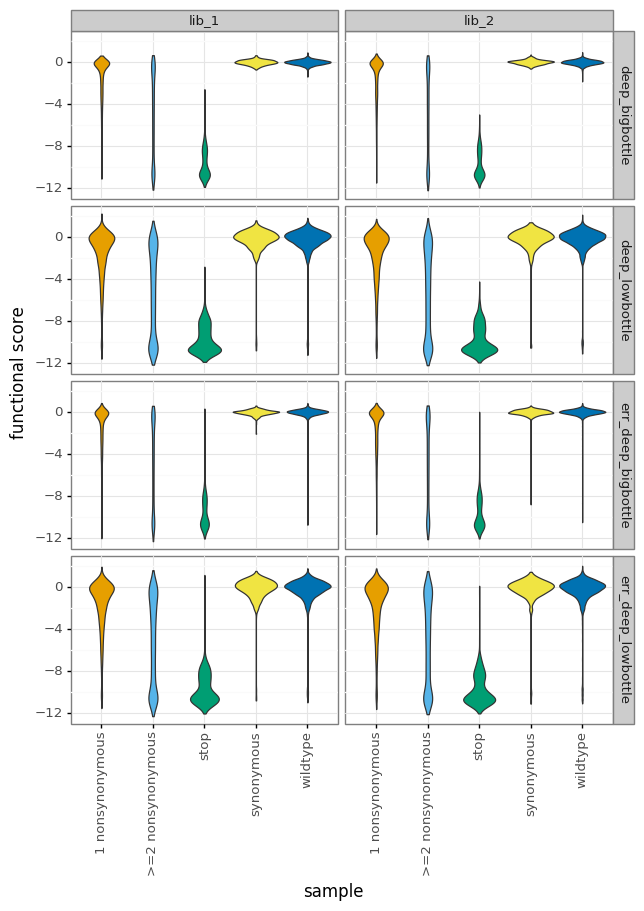

In [40]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('sample') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(7, 9),
          axis_text_x=element_text(angle=90)) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

We see the expected behavior: stop codon variants have low scores,
nonsynonymous variants have a spread of scores, and wildtype /
synonymous variants have scores around zero. Note, however, that when
there are low bottlenecks or sequencing errors then sometimes even
wildtype / synonymous variants end up with low scores due to the errors
or bottlenecking noise.

# Functional scores versus phenotype

Since we simulated the data, we know the *true* observed phenotype for
each variant. We can therefore correlate the true phenotype with the
observed functional score. Note that given how we defined things above,
we expect the $\log_2$ of the true phenotype to equal the observed
functional score.

We add the true phenotypes to our data frame of functional scores:

In [41]:
func_scores = (
    func_scores
    .assign(observed_phenotype=lambda x: x.apply(
                phenosimulator.observedPhenotype, axis=1),
            latent_phenotype=lambda x: x.apply(
                phenosimulator.latentPhenotype, axis=1),
            log_observed_phenotype=lambda x: scipy.log(
                x.observed_phenotype) / scipy.log(2),
            )
    )

For highly deleterious mutations at some point it becomes irrelevant to
estimate the exact score as long as we know that it’s very low. In fact,
we don’t expect to be able to accurately estimate the score for highly
impaired variants with very low scores.

So we also calculate a “clipped” score where we simply assign all
functional scores and log observed phenotypes less than -8 to a value of
-8. The reason is that the simulated experiments don’t appear to
estimate values much lower than -8:

In [42]:
score_clip = -8
func_scores = (
    func_scores
    .assign(func_score_clipped=lambda x: scipy.clip(
                    x.func_score, score_clip, None),
            log_observed_phenotype_clipped=lambda x: scipy.clip(
                    x.log_observed_phenotype, score_clip, None)
            )
    )

Now plot the correlation after this clipping at the low end:

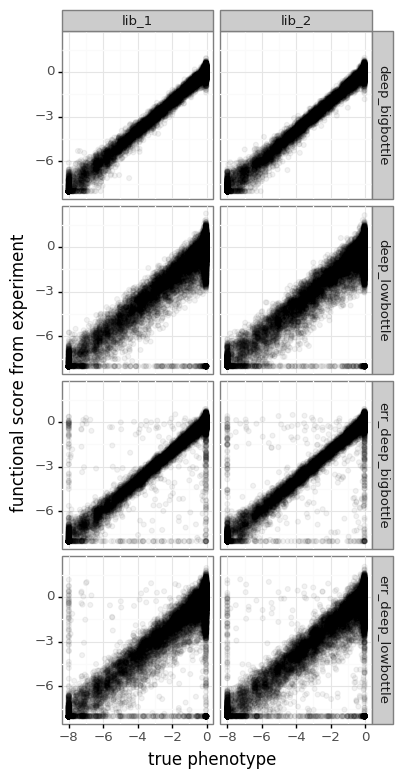

In [43]:
p = (
    ggplot(func_scores,
           aes('log_observed_phenotype_clipped', 'func_score_clipped')) +
    geom_point(alpha=0.05) +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(4, 9)) +
    xlab('true phenotype') +
    ylab('functional score from experiment')
    )
_ = p.draw()

Finally, calculate the Pearson correlation coefficients for the clipped
data. We see below that a small (low) bottleneck and sequencing errors
decrease the accuracy with which the measured
functional scores correlate with the true phenotype:

In [44]:
corr = (
    func_scores
     .groupby(['library', 'post_sample'])
     .apply(lambda x: x['func_score_clipped'].corr(
                      x['log_observed_phenotype_clipped'],
                      method='pearson'))
     .rename('Pearson correlation')
     .reset_index()
     .pivot_table(index='post_sample',
                  values='Pearson correlation',
                  columns='library')
     )

corr.round(3)

library,lib_1,lib_2
post_sample,,
deep_bigbottle,0.996,0.996
deep_lowbottle,0.943,0.945
err_deep_bigbottle,0.976,0.973
err_deep_lowbottle,0.925,0.921
